# Visualize dataset

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
from omegaconf import OmegaConf

import event_prediction
from event_prediction.data.data_utils import download_data_from_url
import openpyxl

In [2]:

url = "https://obj.umiacs.umd.edu/eventprediction/transactions_small.tgz"  # 1k transactions
# url = "https://obj.umiacs.umd.edu/eventprediction/transactions_med.tgz"  # 1m transactions
# url = "https://obj.umiacs.umd.edu/eventprediction/transactions.tgz"  # 25m transactions
data = download_data_from_url(url)
print("Extracting...")
data = extract(data)
print("Creating dataframe...")
df = pd.read_csv(data)

print(f"Total rows: {df.shape[0]}, total columns: {df.shape[1]}")
df.head()

Extracting...
Creating dataframe...
Total rows: 1000, total columns: 16


,Unnamed: 0,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No
1,1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
2,2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
3,3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No
4,4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No


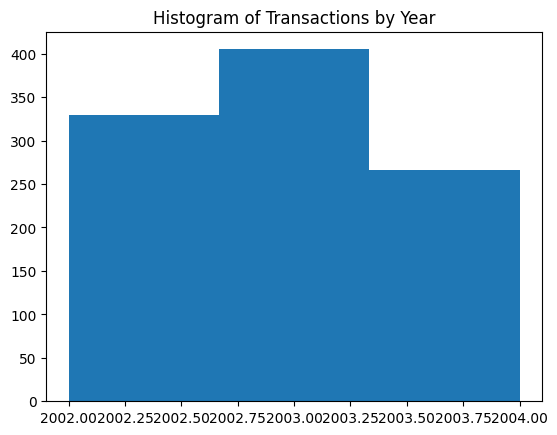

In [10]:
plt.hist(df['Year'], bins=len(df['Year'].unique()))
plt.title('Histogram of Transactions by Year')
plt.show()

In [3]:
cfg_dir = "event_prediction/config"
cfg = OmegaConf.load(f"{cfg_dir}/pre_process_data.yaml")
data_cfg = OmegaConf.load(f"{cfg_dir}/data/ibm_fraud_transaction_small.yaml")
token_cfg = OmegaConf.load(f"{cfg_dir}/tokenizer/composite.yaml")

tokenizer = event_prediction.get_tokenizer(token_cfg, data_cfg)

In [4]:

normed_data = tokenizer.normalize(df)
normed_data.head()

,User,Card,Use Chip,Merchant State,MCC,Errors?,top_mcc,top_chip,Amount,Hour,total_minutes_from_last,Is Fraud?,is_online,avg_dollar_amt,std_dollar_amt
0,0,0,SwipeTransaction,CA,5300,<NA>,5411,SwipeTransaction,8,0,0,True,False,5,5
1,0,0,SwipeTransaction,CA,5411,<NA>,5411,SwipeTransaction,2,0,1,True,False,5,5
2,0,0,SwipeTransaction,CA,5411,<NA>,5411,SwipeTransaction,7,0,7,True,False,5,5
3,0,0,SwipeTransaction,CA,5651,<NA>,5411,SwipeTransaction,8,5,5,True,False,5,5
4,0,0,SwipeTransaction,CA,5912,<NA>,5411,SwipeTransaction,7,0,5,True,False,5,5


In [5]:
wordified_data, labels = tokenizer.pretokenize(normed_data)
wordified_data.head()

0    SwipeTransaction_CA_5300_<NA>_5411_SwipeTransa...
1    SwipeTransaction_CA_5411_<NA>_5411_SwipeTransa...
2    SwipeTransaction_CA_5411_<NA>_5411_SwipeTransa...
3    SwipeTransaction_CA_5651_<NA>_5411_SwipeTransa...
4    SwipeTransaction_CA_5912_<NA>_5411_SwipeTransa...
dtype: object

In [6]:
tokenized_data = tokenizer.model(wordified_data)
tokenized_data.head()

0    SwipeTransaction_CA_5300_<NA>_5411_SwipeTransa...
1    SwipeTransaction_CA_5411_<NA>_5411_SwipeTransa...
2    SwipeTransaction_CA_5411_<NA>_5411_SwipeTransa...
3    SwipeTransaction_CA_5651_<NA>_5411_SwipeTransa...
4    SwipeTransaction_CA_5912_<NA>_5411_SwipeTransa...
dtype: object

In [7]:
post_processed_data = tokenizer.post_process(tokenized_data, labels)
post_processed_data[:5]

['User',
 'Card',
 'SwipeTransaction_CA_5300_<NA>_5411_SwipeTransaction_8_0_0_True_False_5_5',
 'SwipeTransaction_CA_5411_<NA>_5411_SwipeTransaction_2_0_1_True_False_5_5',
 'SwipeTransaction_CA_5411_<NA>_5411_SwipeTransaction_7_0_7_True_False_5_5']

In [14]:
# Optionally save a subset of the dataset if you wish.

# subset_size = 1e6
# df.head(int(subset_size)).to_csv('temp.csv', index=False)
# with tarfile.open('transactions_med.tgz', 'w:gz') as f:
#     f.add('temp.csv')

In [18]:
import pandas as pd


path = "/Users/alex/Documents/School/Maryland/Research/event_prediction/data/submit/raw.csv"
df = pd.read_csv(path)

# Convert unixReviewTime to human-readable format
df['unixReviewTime'] = pd.to_datetime(df['unixReviewTime'], unit='s')

# Mapping column names
column_mapping = {
    'reviewerID': 'User',
    'unixReviewTime': 'Time',
    'overall': 'Rating',
    'verified': 'Verified'
}

# Rename the columns
df.rename(columns=column_mapping, inplace=True)

# Convert Time to only include HH:MM:SS
# df['Time'] = df['Time'].dt.strftime('%H:%M:%S')
# df['Time'] = df['Time'].dt.strftime('%d/%m/%Y')

import random
# Generate random times
random_times = [f'{random.randint(0, 23):02}:{random.randint(0, 59):02}:{random.randint(0, 59):02}' for _ in range(len(df))]

# Replace the Time column with random times
df['Time'] = random_times

# Truncate ASIN and User IDs to the last 5 characters
df['User'] = df['User'].apply(lambda x: x[-5:])
df['asin'] = df['asin'].apply(lambda x: x[-5:])

# Replace True/False with T/F
df['Verified'] = df['Verified'].apply(lambda x: 'T' if x else 'F')

# Sort the DataFrame by 'User' and 'Time'
df_sorted = df.sort_values(by=['User', 'Time'])

# Group the data by 'User'
grouped = df_sorted.groupby('User')


In [22]:
# Select the first 5 sequences
raw_25 = df_sorted.head(25)

# Display the first 5 sequences
print(raw_25)

# Save the reshaped DataFrame as a CSV file
# reshaped_df_first_5_sequences.to_csv('formatted_sequences.csv')

# Save the reshaped DataFrame as an Excel file
raw_25.to_excel('raw_25.xlsx', index=True)


      User      Time   asin Verified  Rating
343  04DPR  06:33:12  89003        T       5
344  04DPR  07:56:57  PHDCE        T       5
345  04DPR  16:43:36  W3HA0        T       5
346  04DPR  17:40:19  3B9US        T       5
342  04DPR  20:47:33  WEQ7G        T       5
159  07PY4  01:30:30  ZPQX8        T       4
158  07PY4  02:47:15  44371        T       4
157  07PY4  03:29:16  1RDVQ        T       3
154  07PY4  07:14:11  G97Z6        T       5
160  07PY4  10:59:07  58202        T       5
161  07PY4  11:56:50  RYN5Y        T       4
155  07PY4  15:41:09  PZ03O        T       4
156  07PY4  16:47:49  GZK6I        T       3
162  07PY4  21:10:29  91701        T       4
270  0PVBG  05:25:04  09514        T       5
269  0PVBG  09:58:37  7QCGS        T       5
271  0PVBG  11:16:25  9GDQ4        T       5
268  0PVBG  15:33:38  L7C82        T       5
272  0PVBG  16:50:48  6NGT4        T       5
274  141XY  03:56:51  JVHCM        T       5
273  141XY  06:55:16  5N1ZO        T       5
278  141XY

In [19]:

# Function to split events into sequences of 5 events each and format them
def split_and_format_sequences(user_df, n_events=5):
    sequences = []
    for i in range(0, len(user_df), n_events):
        seq = user_df.iloc[i:i+n_events]
        if len(seq) == n_events:
            sequences.append(seq.values.flatten())
    return sequences

# Apply the function to each group and create a new DataFrame
all_sequences = []
user_indices = []
for name, group in grouped:
    user_sequences = split_and_format_sequences(group)
    all_sequences.extend(user_sequences)
    user_indices.extend([name] * len(user_sequences))

# Determine the number of events and features dynamically
num_features_per_event = 5  # User, Time, Asin, Verified, Rating
num_events = len(all_sequences[0]) // num_features_per_event

# Create multi-level column names
columns = []
for i in range(1, num_events // num_features_per_event + 1):
    columns.extend([(f'Event {i}', 'User'), (f'Event {i}', 'Time'), (f'Event {i}', 'Asin'), (f'Event {i}', 'Verified'), (f'Event {i}', 'Rating')])

# Adjust columns to match the actual data length
if len(all_sequences[0]) != len(columns):
    num_events = len(all_sequences[0]) // num_features_per_event
    columns = []
    for i in range(1, num_events + 1):
        columns.extend([(f'Event {i}', 'User'), (f'Event {i}', 'Time'), (f'Event {i}', 'Asin'), (f'Event {i}', 'Verified'), (f'Event {i}', 'Rating')])

# Create the multi-level index for the columns
multi_index = pd.MultiIndex.from_tuples(columns, names=['Event', 'Feature'])

# Create the reshaped DataFrame
reshaped_df = pd.DataFrame(all_sequences, columns=multi_index)

# Set the User column as the index
reshaped_df.index = user_indices
reshaped_df.index.name = 'User'

# Remove User columns from events
for i in range(1, num_events + 1):
    reshaped_df.drop((f'Event {i}', 'User'), axis=1, inplace=True)

# Select the first 5 sequences
reshaped_df_first_5_sequences = reshaped_df.head(5)

# Display the first 5 sequences
print(reshaped_df_first_5_sequences)

# Save the reshaped DataFrame as a CSV file
# reshaped_df_first_5_sequences.to_csv('formatted_sequences.csv')

# Save the reshaped DataFrame as an Excel file
reshaped_df_first_5_sequences.to_excel('formatted_sequences.xlsx', index=True)


Event     Event 1                          Event 2                         \
Feature      Time   Asin Verified Rating      Time   Asin Verified Rating   
User                                                                        
04DPR    06:33:12  89003        T      5  07:56:57  PHDCE        T      5   
07PY4    01:30:30  ZPQX8        T      4  02:47:15  44371        T      4   
0PVBG    05:25:04  09514        T      5  09:58:37  7QCGS        T      5   
141XY    03:56:51  JVHCM        T      5  06:55:16  5N1ZO        T      5   
141XY    16:53:18  6OXSY        T      5  17:29:36  IPAG6        T      4   

Event     Event 3                          Event 4                         \
Feature      Time   Asin Verified Rating      Time   Asin Verified Rating   
User                                                                        
04DPR    16:43:36  W3HA0        T      5  17:40:19  3B9US        T      5   
07PY4    03:29:16  1RDVQ        T      3  07:14:11  G97Z6        T      5  

In [226]:
import pandas as pd
import numpy as np
import string
import random

# Function to generate a random 4-character string
def random_string(length=4):
    letters = string.ascii_uppercase
    return ''.join(random.choice(letters) for _ in range(length))

# Create a DataFrame with 5 sets of 5 transactions each
user_ids = [random_string() for _ in range(5)]
data = {
    'Set': np.repeat(np.arange(1, 6), 5),
    'Transaction': np.tile(np.arange(1, 6), 5),
    'User': np.repeat(user_ids, 5),  # Assign a single user per row (set)
    'State': np.random.choice(['NY', 'CA', 'TX', 'FL'], size=25),
    'Timestamp': pd.date_range(start='2024-07-01', periods=25, freq='D').strftime('%d-%m-%Y'),
    'Amount': np.random.randint(50, 100, size=25),
    'Is_Fraud': np.random.choice(["True", "False"], size=25, p=[0.2, 0.8])
}



In [252]:
df = pd.DataFrame(data)

# Ensure the last transaction in each sequence is marked with "?"
for i in range(4, 25, 5):
    df.at[i, 'Is_Fraud'] = '?'

# Function to split events into sequences of 5 events each and format them
def split_and_format_sequences(user_df, n_events=5):
    sequences = []
    for i in range(0, len(user_df), n_events):
        seq = user_df.iloc[i:i+n_events]
        if len(seq) == n_events:
            sequences.append(seq.values.flatten())
    return sequences


# Mapping column names
column_mapping = {
    # 'User': 'User',
    'Timestamp': 'Time',
    'Is_Fraud': 'Is Fraud',
    # 'verified': 'Verified'
}

cols = ["User", "State", "Time", "Amount", "Is Fraud"]

# Rename the columns
df.rename(columns=column_mapping, inplace=True)

# Sort the DataFrame by 'User' and 'Time'
df_sorted = df.sort_values(by=['User', 'Time'])
df_sorted = df_sorted[cols]

user_list = list(set(df["User"]))
user_list.sort(reverse=True)

df_sorted


# Display the DataFrame
# print(df)

,User,State,Time,Amount,Is Fraud
0,PYNX,CA,01-07-2024,78,False
1,PYNX,NY,02-07-2024,97,False
2,PYNX,TX,03-07-2024,69,True
3,PYNX,FL,04-07-2024,98,False
4,PYNX,TX,05-07-2024,52,?
10,SVEK,TX,11-07-2024,50,False
11,SVEK,FL,12-07-2024,53,False
12,SVEK,TX,13-07-2024,69,False
13,SVEK,NY,14-07-2024,94,False
14,SVEK,NY,15-07-2024,64,?


WBUB
UCAH
TLNO
SVEK
PYNX


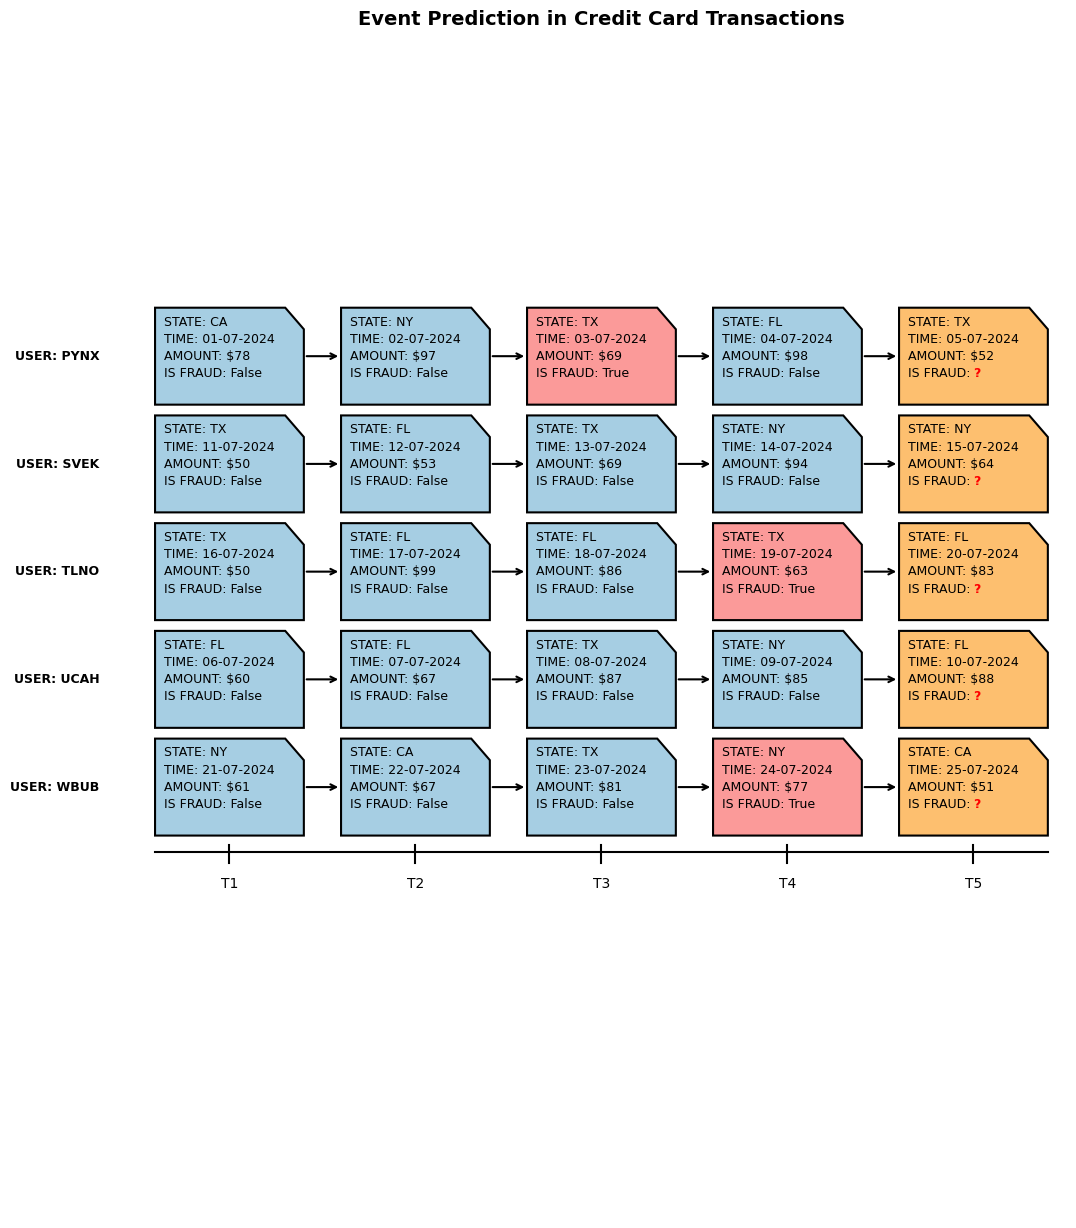

In [253]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import numpy as np

# Function to create a custom shape with the top right corner cut off
def create_custom_card(x, y, width, height, color):
    vertices = [
        (x - width / 2, y - height / 2),  # bottom-left
        (x + width / 2, y - height / 2),  # bottom-right
        (x + width / 2, y + height / 2 - 0.1),  # top-right (cut-off)
        (x + width / 2 - 0.1, y + height / 2),  # top-right (cut-off)
        (x - width / 2, y + height / 2),  # top-left
        (x - width / 2, y - height / 2)   # back to bottom-left
    ]
    codes = [patches.Path.MOVETO, patches.Path.LINETO, patches.Path.LINETO, patches.Path.LINETO, patches.Path.LINETO, patches.Path.CLOSEPOLY]
    path = patches.Path(vertices, codes)
    patch = patches.PathPatch(path, facecolor=color, edgecolor='black', linewidth=1.5)
    return patch

# Create figure
fig, ax = plt.subplots(figsize=(12, 15))

# Adjust layout to reduce space between title and sequences
plt.subplots_adjust(top=0.9)

# Define y positions for each sequence with reduced spacing between rows
y_positions = np.linspace(2, 4, 5)  # Reduced spacing between rows

# Adjust the width and height of each custom card shape
card_width = 0.8
card_height = 0.45
text_spacing = 0.08

# Define the colors for each fraud status
color_mapping = {
    'T': 'fb9a99',  # Red
    'F': 'a6cee3',  # Blue
    '?': 'fdbf6f'  # Yellow
}

# Iterate over each sequence
for user_num, y_position in enumerate(y_positions):
    user_id = user_list[user_num]
    print(user_id)
    subset = df_sorted[df_sorted['User'] == user_id]
    x_positions = np.linspace(1, 5, 5)
    
    # Plot each transaction
    # user = subset['User'].iloc[0]  # Get the user for this row
    user = user_id
    plt.text(0.3, y_position, f'USER: {user}', ha="right", va="center", fontsize=9, weight='bold')
    for i, (index, row) in enumerate(subset.iterrows()):
        x = x_positions[i]
        state = row['State']
        timestamp = row['Time']
        amount = row['Amount']
        fraud = row['Is Fraud']
        color = "#" + color_mapping.get(fraud[0])
        
        
        card_box = create_custom_card(x, y_position, card_width, card_height, color)
        ax.add_patch(card_box)
        plt.text(x - 0.35, y_position + (2 * text_spacing), f'STATE: {state}', ha="left", va="center", fontsize=9)
        plt.text(x - 0.35, y_position + (1 * text_spacing), f'TIME: {timestamp}', ha="left", va="center", fontsize=9)
        plt.text(x - 0.35, y_position + (0 * text_spacing), f'AMOUNT: ${amount}', ha="left", va="center", fontsize=9)
        if fraud == '?':
            plt.text(x - 0.35, y_position - (1 * text_spacing), f'IS FRAUD: ', ha="left", va="center", fontsize=9)
            plt.text(x, y_position - (1 * text_spacing), f'{fraud}', ha="left", va="center", fontsize=9, color='red', weight='bold')
        else:
            plt.text(x - 0.35, y_position - (1 * text_spacing), f'IS FRAUD: {fraud}', ha="left", va="center", fontsize=9)

    # Add arrows to connect the transactions
    for i in range(len(x_positions) - 1):
        ax.annotate('', xy=(x_positions[i + 1] - 0.4, y_position), xytext=(x_positions[i] + 0.4, y_position),
                    arrowprops=dict(facecolor='black', arrowstyle='->', lw=1.5))

# Add a single timeline at the bottom of all transactions
bottom_y_position = y_positions[-1] - 1.8  # Adjust to place it right under the last row
plt.plot([0.6, 5.4], [bottom_y_position - 0.5, bottom_y_position - 0.5], color='black', lw=1.5)
for i, x in enumerate(x_positions):
    plt.text(x, bottom_y_position - 0.65, f'T{i + 1}', ha='center', va='center', fontsize=10)
    plt.plot([x, x], [bottom_y_position - 0.55, bottom_y_position - 0.47], color='black', lw=1.5)

# Set limits and hide axes
ax.set_xlim(0.5, 5.5)
ax.set_ylim(0, 5.5)  # Adjusted ylim to keep rows closer to title
ax.axis('off')

# Add title
plt.title("Event Prediction in Credit Card Transactions", fontsize=14, weight='bold')
plt.savefig('credit_card_transactions.png', format='png', bbox_inches='tight')
# Show the plot
plt.show()


In [281]:
from openpyxl import load_workbook
from openpyxl.styles import PatternFill

# Apply the function to each group and create a new DataFrame
# Replace True/False with T/F
df_sorted['Is Fraud'] = df_sorted['Is Fraud'].apply(lambda x: x[0])

all_sequences = []
user_indices = []

grouped = df_sorted.groupby('User')

for name, group in grouped:
    print(name)
    print(group)
    user_sequences = split_and_format_sequences(group)
    all_sequences.extend(user_sequences)
    user_indices.extend([name] * len(user_sequences))

# Determine the number of events and features dynamically
num_features_per_event = 5  # User, Time, Asin, Verified, Rating
num_events = len(all_sequences[0]) // num_features_per_event

# Create multi-level column names
columns = []
for i in range(1, num_events // num_features_per_event + 1):
    temp_columns = []
    for j in cols:
        temp_columns.append((f'Event {i}', j))
    columns.extend(temp_columns)
    # columns.extend([(f'Event {i}', 'User'), (f'Event {i}', 'Time'), (f'Event {i}', 'Asin'), (f'Event {i}', 'Verified'), (f'Event {i}', 'Rating')])

# Adjust columns to match the actual data length
if len(all_sequences[0]) != len(columns):
    num_events = len(all_sequences[0]) // num_features_per_event
    columns = []
    for i in range(1, num_events + 1):
        # columns.extend([(f'Event {i}', 'User'), (f'Event {i}', 'Time'), (f'Event {i}', 'Asin'), (f'Event {i}', 'Verified'), (f'Event {i}', 'Rating')])
        temp_columns = []
        for j in cols:
            temp_columns.append((f'Event {i}', j))
        columns.extend(temp_columns)

# Create the multi-level index for the columns
multi_index = pd.MultiIndex.from_tuples(columns, names=['Event', 'Feature'])

# Create the reshaped DataFrame
reshaped_df = pd.DataFrame(all_sequences, columns=multi_index)

# Set the User column as the index
reshaped_df.index = user_indices
reshaped_df.index.name = 'User'

# Remove User columns from events
for i in range(1, num_events + 1):
    reshaped_df.drop((f'Event {i}', 'User'), axis=1, inplace=True)

# Select the first 5 sequences
reshaped_df_first_5_sequences = reshaped_df.head(5)

# Display the first 5 sequences
print(reshaped_df_first_5_sequences)

# Save the reshaped DataFrame as a CSV file
# reshaped_df_first_5_sequences.to_csv('formatted_sequences.csv')

# Save the reshaped DataFrame as an Excel file
file_path = 'formatted_sequences_IBM.xlsx'
reshaped_df_first_5_sequences.to_excel(file_path, index=True)

# Open the Excel file and modify cell colors
wb = load_workbook(file_path)
ws = wb.active

num_cols = (num_features_per_event - 1)

# Apply colors to the cells
for row in range(4, ws.max_row + 1):  # Starting from the second row to skip the header
    for col in range(2, ws.max_column + 1, num_cols): # go by 4s
        fraud_col = col + (num_cols - 1)
        cell = ws.cell(row=row, column=fraud_col)
        fraud_status = cell.value
        color = color_mapping.get(fraud_status, 'FFFFFFFF')
        fill = PatternFill(fgColor=color, fill_type='solid')
        # print(f"Row {row}, Column {col}: {fraud_status} -> {color}")  # Debug print
        for c in range(num_cols):
            cell = ws.cell(row=row, column=col + c)
            cell.fill = fill

# Save the modified Excel file
wb.save(file_path)

PYNX
   User State        Time  Amount Is Fraud
0  PYNX    CA  01-07-2024      78        F
1  PYNX    NY  02-07-2024      97        F
2  PYNX    TX  03-07-2024      69        T
3  PYNX    FL  04-07-2024      98        F
4  PYNX    TX  05-07-2024      52        ?
SVEK
    User State        Time  Amount Is Fraud
10  SVEK    TX  11-07-2024      50        F
11  SVEK    FL  12-07-2024      53        F
12  SVEK    TX  13-07-2024      69        F
13  SVEK    NY  14-07-2024      94        F
14  SVEK    NY  15-07-2024      64        ?
TLNO
    User State        Time  Amount Is Fraud
15  TLNO    TX  16-07-2024      50        F
16  TLNO    FL  17-07-2024      99        F
17  TLNO    FL  18-07-2024      86        F
18  TLNO    TX  19-07-2024      63        T
19  TLNO    FL  20-07-2024      83        ?
UCAH
   User State        Time  Amount Is Fraud
5  UCAH    FL  06-07-2024      60        F
6  UCAH    FL  07-07-2024      67        F
7  UCAH    TX  08-07-2024      87        F
8  UCAH    NY  09-07-2

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load and clean the data
raw_data_path = '/Users/alex/Documents/School/Maryland/Research/event_prediction/data/submit2/testing.csv'

ind_cols = ["eval experiment folder name", "eval randomize order",	"eval mask all pct", "eval mask each pct", "train randomize order", "train mask all pct", "train mask each pct"]
# import pandas as pd

metrics = ['auc', 'auc last', 'auc consolidated', 'auc last consolidated']
# agg_map = {
#     'auc'
# }

# Step 1: Load the provided raw data with specified header levels
# raw_data_path = 'path/to/your/testing.csv'
raw_df = pd.read_csv(raw_data_path, header=[0], index_col=[0])

# Display the first few rows to inspect the structure
print("Raw Data:")
print(raw_df.head())


Raw Data:
   batches   rows  accuracy       auc  f1 micro  f1 macro  f1 weighted  \
0      211  94316  0.654322  0.703377  0.654322  0.258995     0.558723   
1      210  92843  0.656011  0.704922  0.656011  0.255756     0.556535   
2      212  94337  0.656370  0.701274  0.656370  0.261843     0.562287   
3      210  92966  0.652712  0.700114  0.652712  0.259127     0.558165   
4      214  95765  0.658476  0.707567  0.658476  0.267294     0.566514   

  accuracy consolidated auc consolidated f1 micro consolidated  ... numGPUs  \
0              0.820985         0.727411              0.820985  ...       1   
1              0.819674         0.730636              0.819674  ...       1   
2              0.818237         0.722663              0.818237  ...       1   
3              0.819192         0.723446              0.819192  ...       1   
4              0.817177          0.73162              0.817177  ...       1   

        kWh                               exp  fata-trans  TabBERT  Un

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
file_path = '/Users/alex/Documents/School/Maryland/Research/event_prediction/data/submit2/testing.csv'
data = pd.read_csv(file_path)

# Columns for indexing and aggregation
ind_cols = [
    "eval experiment folder name", "eval randomize order", "eval mask all pct", 
    "eval mask each pct", "train randomize order", "train mask all pct", 
    "train mask each pct"
]
agg_cols = ['auc', 'auc last', 'auc consolidated', 'auc last consolidated']

# Renaming columns to match the required index columns
data.columns = data.columns.str.strip()
# data = data.rename(columns={"exp": "eval experiment folder name"})

# Handling missing values by filling them with NaN (if necessary)
data[agg_cols] = data[agg_cols].apply(pd.to_numeric, errors='coerce')
# Grouping by the index columns and aggregating the mean, std, and count
grouped_data = data.groupby(ind_cols)[agg_cols].agg(['mean', 'std', 'count']).reset_index()

# Removing trailing underscores from column names for consistency
grouped_data.columns = ['_'.join(col).rstrip('_') for col in grouped_data.columns]

# Creating a new column for the desired metric based on the experiment
grouped_data['desired_metric_mean'] = grouped_data.apply(
    lambda row: row['auc last consolidated_mean'] if 'amazon' in row['eval experiment folder name'] else row['auc last_mean'],
    axis=1
)

grouped_data['desired_metric_std'] = grouped_data.apply(
    lambda row: row['auc last consolidated_std'] if 'amazon' in row['eval experiment folder name'] else row['auc last_std'],
    axis=1
)


# Filtering the data as specified before
filtered_data = grouped_data[
    (grouped_data["train mask all pct"] == 0.0) &
    (grouped_data["train mask each pct"] == 0.0) &
    (grouped_data["eval mask all pct"] == 0.0) &
    (grouped_data["eval mask each pct"] == 0.0) &
    (grouped_data["eval randomize order"] == True)
]

# Prepare the data for plotting
plot_data = filtered_data[['eval experiment folder name', 'train randomize order', 'desired_metric_mean', 'desired_metric_std']]

plot_data['Method'] = plot_data['train randomize order'].map({True: 'Train Randomize Order = True', False: 'Train Randomize Order = False'})
plot_data = plot_data.rename(columns={'desired_metric_mean': 'Value', 'desired_metric_std': 'Std'})

# Mapping the experiment names for better readability
plot_data['eval experiment folder name'] = plot_data['eval experiment folder name'].map({
    'EVAL_pretrain_amazon_electronics': 'Amazon Electronics',
    'EVAL_pretrain_amazon_movies': 'Amazon Movies',
    'EVAL_pretrain_ibm': 'Fraud Detection'
})
# Combine the benchmark data with the plot data
plot_data = plot_data.rename(columns={'eval experiment folder name': 'Dataset'})


/var/folders/zz/wbklkpzn7ssgpvgbh7ptnxw00000gn/T/ipykernel_45577/67972560.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data['Method'] = plot_data['train randomize order'].map({True: 'Train Randomize Order = True', False: 'Train Randomize Order = False'})


In [35]:
benchmarks = {
    "Fata-Trans":
        {
            "Fraud Detection": 0.9992,
            "Amazon Electronics": 0.7206,
            "Amazon Movies": 0.8057,
        },
    "TabBERT":
        {
            "Fraud Detection": 0.9985,
            "Amazon Electronics": 0.7098,
            "Amazon Movies": 0.7964,
        },
}
# Convert the benchmark dictionary to a DataFrame
benchmark_data = []
for method, datasets in benchmarks.items():
    for dataset, value in datasets.items():
        benchmark_data.append([method, dataset, value, 0])  # Adding 0 for std deviation as benchmarks don't have it

benchmark_df = pd.DataFrame(benchmark_data, columns=['Method', 'Dataset', 'Value', 'Std'])


,Method,Dataset,Value
0,Fata-Trans,Fraud Detection,0.9992
1,Fata-Trans,Amazon Electronics,0.7206
2,Fata-Trans,Amazon Movies,0.8057
3,TabBERT,Fraud Detection,0.9985
4,TabBERT,Amazon Electronics,0.7098
5,TabBERT,Amazon Movies,0.7964


               Dataset                         Method     Value       Std
18  Amazon Electronics  Train Randomize Order = False  0.602048  0.007964
21  Amazon Electronics   Train Randomize Order = True  0.743897  0.004110
54       Amazon Movies  Train Randomize Order = False  0.606851  0.009055
57       Amazon Movies   Train Randomize Order = True  0.821490  0.008759
90     Fraud Detection  Train Randomize Order = False  0.631620  0.042260
93     Fraud Detection   Train Randomize Order = True  0.971505  0.014534
0      Fraud Detection                     Fata-Trans  0.999200  0.000000
1   Amazon Electronics                     Fata-Trans  0.720600  0.000000
2        Amazon Movies                     Fata-Trans  0.805700  0.000000
3      Fraud Detection                        TabBERT  0.998500  0.000000
4   Amazon Electronics                        TabBERT  0.709800  0.000000
5        Amazon Movies                        TabBERT  0.796400  0.000000


/var/folders/zz/wbklkpzn7ssgpvgbh7ptnxw00000gn/T/ipykernel_45577/1853709059.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x='Dataset', y='Value', hue='Method', data=combined_data, ci=None, capsize=0.1)


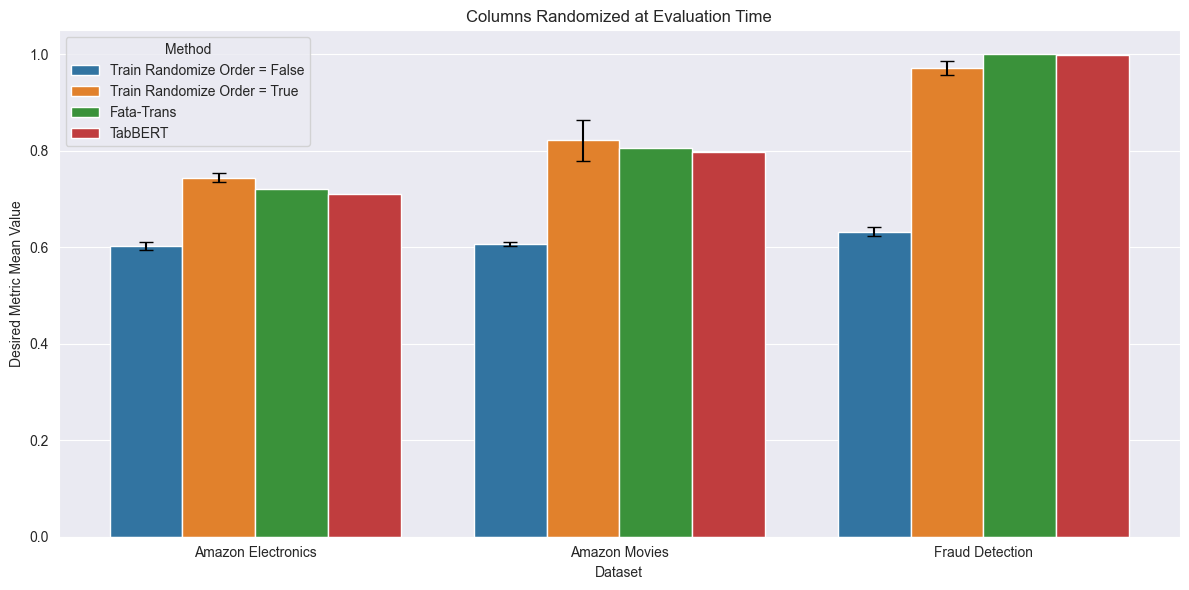

In [40]:
combined_data = pd.concat([plot_data[['Dataset', 'Method', 'Value', 'Std']], benchmark_df])
print(combined_data)
# Plotting the bar chart with error bars
plt.figure(figsize=(12, 6))

# Using seaborn to plot the bar chart
ax = sns.barplot(x='Dataset', y='Value', hue='Method', data=combined_data, ci=None, capsize=0.1)

# Adding the error bars manually for 'Train Randomize Order'
for i, (index, row) in enumerate(plot_data.iterrows()):
    bar = ax.patches[i]
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    std = row['Std']
    ax.errorbar(x, y, yerr=std, fmt='none', c='black', capsize=5)

# Adding labels and title
plt.xlabel('Dataset')
plt.ylabel('Desired Metric Mean Value')
plt.title('Columns Randomized at Evaluation Time')
plt.legend(title='Method')


# Displaying the plot
plt.tight_layout()
plt.savefig('Randomized_Eval.png')
plt.show()